# Measure facial masculinity from video

In [1]:
import os
import sys
import time
import glob
import pickle
import shutil
import logging
import argparse
import traceback
import datetime
import numpy as np
import pandas as pd
import cv2
import dlib
import math
import random
import itertools
import statistics
import mediapipe as mp
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from collections import OrderedDict
from pathlib import Path
from utils import *

## Filter frames
Filter frames extracted in "facial asymmetry measurement (FAVM)" project by euler angles and facial expression.

In [2]:
## filter frames with neutral emotion and small eular angle
def filter_frames(frame_root, score_root, euler_thres=[10, 10, 10], nsample=10):
    
    '''
    Filter frames for measuring facial masculinity.
    
    :param score_root: directory saving euler angles and emotions
    :param euler_thres: thresholds of euler angles
    :param nsample: number of images to be used 
    :return all_frames: a dict saving frame files for all videos
    '''
    
    videos = os.listdir(score_root)
    # emotion and euler angle
    all_eulers = []
    for video in videos:
        # euler angle
        euler_file = os.path.join(score_root, video, 'target_frame_euler.csv')
        if os.path.exists(euler_file):
            df = pd.read_csv(euler_file, sep='\t')
            # emotion
            with open(os.path.join(score_root, video, 'scores_emonet.pkl'), 'rb') as f:
                emos = pickle.load(f)
            emo = emos['align_emos'] # a dataframe
            # neutral or not
            emo['neutral'] = np.where(emo.iloc[:, 1:].values.argmax(axis=1) == 0, 1, 0)
            # merge two dataframes
            df = df.merge(emo[['Frame_ID', 'neutral']], on='Frame_ID')
            df.insert(0, 'Video_ID', video)
            all_eulers.append(df)
    eulers = pd.concat(all_eulers)
    eulers[['alpha', 'beta', 'gamma']] = eulers[['alpha', 'beta', 'gamma']]
    
    g = eulers.loc[eulers.neutral == 1]
    g = g.groupby('Video_ID').apply(lambda x: x.sort_values(by=['alpha','beta','gamma'], key=abs)).reset_index(drop=True)
    tmp = g.loc[(abs(g.alpha) < euler_thres[0]) & (abs(g.beta) < euler_thres[1]) & (abs(g.gamma) < euler_thres[2])].copy()
    if len(tmp) > 0:
        g = tmp.groupby('Video_ID').head(nsample)
    else:
        g = g.groupby('Video_ID').head(nsample)
        
    all_frames = {k: [] for k in set(g.Video_ID)}
    all_imagesizes = {k: None for k in set(g.Video_ID)}
    for _, row in g.iterrows():
        all_frames[row.Video_ID].append(os.path.join(frame_root, row.Video_ID, f'{row.Frame_ID}.jpg'))
    for k in all_frames.keys():
        example_image = cv2.imread(all_frames[k][0])
        all_imagesizes[k] = example_image.shape[:2]
        # print(example_image.shape[:2])
        
    return all_frames, all_imagesizes


In [3]:
# directories saving frames and scores
frame_root = 'test/all_frames'
score_root = 'test/all_scores'
all_frames, all_imagesizes = filter_frames(frame_root, score_root)

In [4]:
# example: filtered frames of video 1239206 
all_frames['1239206']

['test/all_frames/1239206/frame373_msec14920.jpg',
 'test/all_frames/1239206/frame227_msec9080.jpg',
 'test/all_frames/1239206/frame374_msec14960.jpg',
 'test/all_frames/1239206/frame226_msec9040.jpg',
 'test/all_frames/1239206/frame372_msec14880.jpg',
 'test/all_frames/1239206/frame371_msec14840.jpg',
 'test/all_frames/1239206/frame370_msec14800.jpg',
 'test/all_frames/1239206/frame377_msec15080.jpg',
 'test/all_frames/1239206/frame195_msec7800.jpg',
 'test/all_frames/1239206/frame188_msec7520.jpg']

In [5]:
## retrieve 68 landmarks for these filtered frames (already obtained in FAVM project)
# all_2d_landmarks is a dictionary, each key is video ID, each item is a dictionary saving frame ID and 68 landmarks for the corresponding frames
all_2d_landmarks = dict.fromkeys(all_frames.keys())
for k, v in all_frames.items():
    landmarks = {}
    for frame in v:
        framename = frame.split('/')[-1].split('.')[0]
        filename = f'{score_root}/{k}/frame_2d_68pts_encodings.pkl'
        with open(filename, 'rb') as f:
            tmp = pickle.load(f)
        landmarks[framename] = tmp[framename]['2d_landmarks'][0]
    all_2d_landmarks[k] = landmarks

In [6]:
# example: 68 landmarks of frame frame373_msec14920, video 1239206
all_2d_landmarks['1239206']['frame373_msec14920'].shape

(68, 2)

## Align faces

In [7]:
## align all faces and save
align_root = 'gender/align' # directory for saving aligned faces
for vid_id, d in all_2d_landmarks.items():
    Path(f'{align_root}/{vid_id}').mkdir(parents=True, exist_ok=True)
    for frame, landmarks in d.items():
        image = cv2.imread(f'{frame_root}/{vid_id}/{frame}.jpg')
        align = face_align(image, landmarks, desiredLeftEye=(0.4,0.4), desiredFaceWidth=256)
        cv2.imwrite(f'{align_root}/{vid_id}/{frame}.jpg', align)

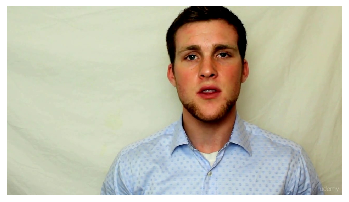

In [8]:
# frame
vid_id = '1239206'
frame_path = all_frames[vid_id][0]
frame_id = frame_path.split('/')[-1].split('.')[0]
image = cv2.imread(frame_path)
plt.imshow(image[:,:,::-1]);plt.axis('off');plt.show()

In [9]:
# landmarks
landmarks = all_2d_landmarks[vid_id][frame_id]

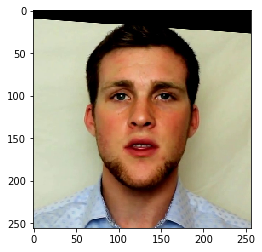

In [10]:
align = face_align(image, landmarks, desiredLeftEye=(0.4,0.4), desiredFaceWidth=256)
plt.imshow(align[:,:,::-1]);plt.show()

## Detect face meshes on aligned faces

In [11]:
# convert landmarks object to np.ndarray (N, 3)
def landmarks_to_np_(landmarks, imagesize):
    arr = []
    for p in landmarks:
        arr.append([p.x, p.y, p.z])
    arr = np.vstack(arr)
    # retrieve absolute distances 
    arr[:, 0] = arr[:, 0] * imagesize[1]
    arr[:, 1] = arr[:, 1] * imagesize[0]
    arr[:, 2] = arr[:, 2] * imagesize[1]
    
    return arr

# function for detecting 478 facial landmarks
mp_face_mesh = mp.solutions.face_mesh
def detect_mesh_landmarks_(image_file):
    
    image = cv2.imread(image_file)
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        refine_landmarks=True,
        max_num_faces=1,
        min_detection_confidence=0.5) as face_mesh:
        # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
        result = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    if not result.multi_face_landmarks:
        return None
    
    return result.multi_face_landmarks[0].landmark

## detect face mesh landmarks: people to be studied
def detect_mesh_landmarks(all_frames, imagesize=(256, 256)):
    
    '''
    Detect face mesh keypoints (478 in total).
    
    :param all_frames: dict saving filtered frames for all videos
    :param all_imagesizes: dict saving image sizes for all videos
    :return all_landamrks: a dict saving face mesh landmarks for all videos
    '''
    
    all_landmarks = {k: [] for k in all_frames.keys()}
    for k, v in all_frames.items():
        landmarks = []           
        for frame in v:
            raw_landmark = detect_mesh_landmarks_(frame)
            if raw_landmark is not None:
                landmark = landmarks_to_np_(raw_landmark, imagesize)
                landmarks.append(landmark)

        all_landmarks[k] = landmarks
    
    return all_landmarks

# rotation angle
def rotation_angle_(landmarks):
    dX = landmarks[pupillaries[1], 0] - landmarks[pupillaries[0], 0]
    dY = landmarks[pupillaries[0], 1] - landmarks[pupillaries[1], 1]
    theta = np.arctan2(dY, dX)
    return theta

# function for rotating keypoints such that pupillaries connection line is horizontal
def rotate_mesh_(landmarks):
    
    theta = rotation_angle_(landmarks)
    c, s = np.cos(theta), np.sin(theta)
    # print(theta)
    # rotation matrix
    R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    # rotation center
    center = (landmarks[pupillaries[0], :] + landmarks[pupillaries[1], :]) / 2
    # rotate keypoints
    new_landmarks = center + (landmarks - center) @ R.T
    
    return new_landmarks

def average_dists_(dists):
    
    # dists: a list of dist dictionary
    if len(dists) == 0:
        raise Exception('No distances to be averaged!')
    elif len(dists) == 1:
        return dists[0]
    else:
        dist = []
        for d in dists:
            df = pd.DataFrame(d, index=[0])
            dist.append(df)
        dist = pd.concat(dist).mean().to_dict()
    return dist

In [12]:
## detect and save face mesh
all_landmarks_file = 'gender/all_mesh_landmarks.pkl'
all_aligned_images = {k: [f'{align_root}/{k}/{x}.jpg' for x in list(v.keys())] for k, v in all_2d_landmarks.items()}
all_landmarks = detect_mesh_landmarks(all_aligned_images)
with open(all_landmarks_file, 'wb') as f:
    pickle.dump(all_landmarks, f)

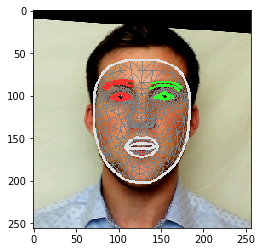

In [13]:
## example: detected face mesh on aligned face
# detect face mesh using aligned face
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=1,
    min_detection_confidence=0.5) as face_mesh:
    # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
    result = face_mesh.process(cv2.cvtColor(align, cv2.COLOR_BGR2RGB))
    
# draw face mesh
annotated_image = align.copy()
face_landmarks = result.multi_face_landmarks[0]
mp_drawing.draw_landmarks(
    image=annotated_image,
    landmark_list=face_landmarks,
    connections=mp_face_mesh.FACEMESH_TESSELATION,
    landmark_drawing_spec=None,
    connection_drawing_spec=mp_drawing_styles
    .get_default_face_mesh_tesselation_style())
mp_drawing.draw_landmarks(
    image=annotated_image,
    landmark_list=face_landmarks,
    connections=mp_face_mesh.FACEMESH_CONTOURS,
    landmark_drawing_spec=None,
    connection_drawing_spec=mp_drawing_styles
    .get_default_face_mesh_contours_style())
mp_drawing.draw_landmarks(
    image=annotated_image,
    landmark_list=face_landmarks,
    connections=mp_face_mesh.FACEMESH_IRISES,
    landmark_drawing_spec=None,
    connection_drawing_spec=mp_drawing_styles
    .get_default_face_mesh_iris_connections_style())

plt.imshow(annotated_image[:,:,::-1]);plt.show()

## Calculate distances

In [14]:
## correspondence between 468 landmarks and key points for masculinity measurement
P1 = [33, 263]
P2 = [133, 362]
P3 = [234, 454]
P4 = [129, 358]
P5 = [61, 291]
P6 = [58, 288]
P7 = [10, 152]
pupillaries = [468, 473]
right_eyebrow = [46, 52, 55]
left_eyebrow = [276, 282, 285]
eyebrows = right_eyebrow + left_eyebrow
points = {'P1': P1, 'P2': P2, 'P3': P3, 'P4': P4, 'P5': P5, 'P6': P6, 'pupillaries': pupillaries, 'eyebrows': eyebrows}

In [15]:
def get_distances_(landmarks):
    
    interpupillary = np.linalg.norm(landmarks[pupillaries[1]] - landmarks[pupillaries[0]])
    scale = 1 / interpupillary
    D0 = sum([abs(landmarks[P7[1],1] - landmarks[i,1]) for i in eyebrows]) / len(eyebrows) * scale
    D1 = np.linalg.norm(landmarks[P1[1]] - landmarks[P1[0]]) * scale
    D2 = np.linalg.norm(landmarks[P2[1]] - landmarks[P2[0]]) * scale
    D3 = np.linalg.norm(landmarks[P3[1]] - landmarks[P3[0]]) * scale
    D4 = np.linalg.norm(landmarks[P4[1]] - landmarks[P4[0]]) * scale
    D5 = np.linalg.norm(landmarks[P5[1]] - landmarks[P5[0]]) * scale
    D6 = np.linalg.norm(landmarks[P6[1]] - landmarks[P6[0]]) * scale
    D7 = (landmarks[P7[1],1] - landmarks[P7[0],1]) * scale
    D8 = (abs(landmarks[P7[1],1] - landmarks[P1[0],1]) + abs(landmarks[P7[1],1] - landmarks[P1[1],1])) / 2 * scale
    
    return {'D0': D0, 'D1': D1, 'D2': D2, 'D3': D3, 'D4': D4, 'D5': D5, 'D6': D6, 'D7': D7, 'D8': D8}

def get_distances(all_landmarks):
    
    '''
    Calculate distances for measuring facial masculinity and asymmetry.
    
    :param all_landmarks: dict saving face mesh landmarks for all videos
    :return all_distances, avg_distances: a dict saving distances for all videos, a dataframe saving average distances for all videos
    '''
    
    all_distances = {k: [] for k in all_landmarks.keys()}
    avg_distances = pd.DataFrame(columns=['ID', 'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8'])
    for i, (k, v) in enumerate(all_landmarks.items()):
        if len(v) == 0:
            continue
        distances = [get_distances_(landmark) for landmark in v]
        all_distances[k] = distances
        avg_distances.loc[i] = [k] + list(average_dists_(distances).values())
        
    return all_distances, avg_distances


In [16]:
## load and rotate landmarks for calculating distances
all_landmarks_file = 'gender/all_mesh_landmarks.pkl'
with open(all_landmarks_file, 'rb') as f:
    all_landmarks = pickle.load(f)
for k, v in all_landmarks.items():
    new_landmark = []
    for landmark in v:
        new = rotate_mesh_(landmark)
        new_landmark.append(new)
    all_landmarks[k] = new_landmark

In [17]:
## calculate distances and average distances
gender_est_file = 'gender/gender_est.csv'
all_distances, avg_distances = get_distances(all_landmarks)
gender_est = pd.read_csv(gender_est_file, sep='\t')
gender_est['ID'] = gender_est['Video_ID'].apply(str)
avg_distances['ID'] = avg_distances['ID'].apply(str)
avg_distances = avg_distances.merge(gender_est[['ID', 'gender']], on='ID')
male_distances = avg_distances.loc[avg_distances.gender=='Male']
female_distances = avg_distances.loc[avg_distances.gender=='Female']

## Calculate facial masculinity

In [18]:
def measure_facial_masculinity(dist):
        
    # facial masculinity for faces in study
    if 'gender' in dist.columns:
        mas = pd.DataFrame({'ID': dist.iloc[:,0], 'gender': dist['gender']})
    else:
        mas = pd.DataFrame({'ID': dist.iloc[:,0]})
    mas['eye_size'] = (dist['D1'] - dist['D2']) / 2
    mas['lower_height'] = dist['D8'] / dist['D7']
    mas['cheekbone_prominence'] = dist['D3'] / dist['D6']
    mas['width_lower'] = dist['D3'] / dist['D8']
    mas['eyebrow_height'] = dist['D0']
    
    # mas['facial_masculinity'] = mas['lower_height'] - mas['width_lower'] - mas['eye_size'] - mas['eyebrow_height']
    mas['facial_masculinity'] = mas['lower_height'] - mas['width_lower'] - mas['eye_size'] - mas['eyebrow_height'] - mas['cheekbone_prominence'] 
        
    return mas

In [19]:
## measure facial masculinity
male_masculinity = measure_facial_masculinity(male_distances).sort_values(by='ID', key=lambda x: x.astype(int)).reset_index(drop=True)
female_masculinity = measure_facial_masculinity(female_distances).sort_values(by='ID', key=lambda x: x.astype(int)).reset_index(drop=True)
masculinity = pd.concat([male_masculinity, female_masculinity]).reset_index(drop=True)

## Calculate facial asymmetry

In [20]:
def measure_facial_asymmetry_(landmarks):
    
    # scale factor
    interpupillary = np.linalg.norm(landmarks[pupillaries[1]] - landmarks[pupillaries[0]])
    scale = 1 / interpupillary
    
    mid_x, diffs_y = [], []
    for i in range(1, 7):
        idx = points[f'P{i}']
        mid_x.append((landmarks[idx[0],0] + landmarks[idx[1],0]) / 2)
        diffs_y.append(abs(landmarks[idx[0],1] - landmarks[idx[1],1]) * scale)
    vert_asym = sum(diffs_y)
    
    diffs_x = [abs(e[1] - e[0]) for e in itertools.permutations(mid_x, 2)]
    hori_asym = sum(diffs_x) / 2 * scale
    
    return hori_asym, vert_asym

def measure_facial_asymmetry(all_landmarks):
    
    '''
    Measure facial asymmetry.
    
    :param all_landmarks: dict saving landmarks for all videos
    :return mas: a dataframe saving facial asymmetry for all videos
    '''
    
    asym = pd.DataFrame(columns=['ID', 'horizontal_asymmetry', 'vertical_asymmetry'])
    for i, (k, v) in enumerate(all_landmarks.items()):
        if len(v) == 0:
            asym.loc[i] = [k, None, None]
            continue
        hori_asyms, vert_asyms = [], []
        for landmark in v:
            hori_asym, vert_asym = measure_facial_asymmetry_(landmark)
            hori_asyms.append(hori_asym)
            vert_asyms.append(vert_asym)
        asym.loc[i] = [k] + [statistics.mean(hori_asyms), statistics.mean(vert_asyms)]
    
    return asym


In [21]:
# asymmetry from facial features
asymmetry = measure_facial_asymmetry(all_landmarks)
asymmetry = asymmetry.dropna().sort_values(by='ID', key=lambda x: x.astype(int)).reset_index(drop=True)

## Result: concatenate facial masculinity and facial asymmetry

In [22]:
face_result = pd.merge(masculinity, asymmetry, on='ID')
face_result

,ID,gender,eye_size,lower_height,cheekbone_prominence,width_lower,eyebrow_height,facial_masculinity,horizontal_asymmetry,vertical_asymmetry
0,26484,Male,0.426770,0.692002,1.109501,1.213685,2.141361,-4.199316,0.511868,0.078483
1,98706,Male,0.431948,0.690953,1.114845,1.140399,2.157387,-4.153625,0.270754,0.109735
2,211874,Male,0.400655,0.700631,1.115156,1.164630,1.993105,-3.972915,0.395586,0.169731
3,740764,Male,0.409531,0.686905,1.106309,1.326234,1.835721,-3.990890,0.360949,0.078545
4,1028790,Male,0.416951,0.693998,1.126461,1.187802,2.098469,-4.135685,0.187849,0.065624
5,1220862,Male,0.429031,0.678965,1.110266,1.207992,2.075820,-4.144145,0.309980,0.042367
6,1239206,Male,0.427990,0.692436,1.126973,1.131257,2.148199,-4.141984,0.360610,0.130683
7,2541498,Male,0.421076,0.679511,1.145976,1.210527,2.011810,-4.109876,0.248944,0.065993
8,3104866,Male,0.434674,0.689394,1.127293,1.237419,1.908469,-4.018461,0.326426,0.068887
9,3255896,Male,0.441043,0.693309,1.106227,1.175832,2.179390,-4.209183,1.105180,0.077017


# Measure facial masculinity from image

## Create a test set of images
If there is a set of verification images, save it in a directory. Here I create a set of images from video frames to demonstrate.

In [23]:
# create a set of images from frames: each video choose one frame at random
# and save these images in verify_root
verify_root = 'gender/verify'
if os.path.exists(verify_root):
    shutil.rmtree(verify_root)
os.mkdir(verify_root)
verify_frames = []
for vid_id, paths in all_frames.items():
    path = random.choice(paths)
    verify_frames.append(path)
    shutil.copy(path, f"{verify_root}/{vid_id}_{path.split('/')[-1].split('.')[0]}.jpg")
verify_frames[:5]

['test/all_frames/3255896/frame1_msec33.jpg',
 'test/all_frames/3104866/frame333_msec11100.jpg',
 'test/all_frames/4176302/frame1916_msec63867.jpg',
 'test/all_frames/3508904/frame1801_msec60033.jpg',
 'test/all_frames/3774670/frame49_msec1633.jpg']

## Detect 68 landmarks

In [24]:
# suppose each image contains one and. only one face
verify_images = glob.glob(f'{verify_root}/*.jpg', recursive=True)
verify_landmarks = {}
for image_file in verify_images:
    image_name = image_file.split('/')[-1].split('.')[0]
    image = cv2.imread(image_file)
    # face location: suppose only
    face_location = face_detector(image)[0]
    # 68 landmarks
    landmarks = landmarks_to_np(pose_predictor_68_point(image, face_location))
    verify_landmarks[image_name] = landmarks

## Align faces

In [25]:
## align all faces and save
verify_align_root = 'gender/verify_align' # directory for saving aligned faces
Path(verify_align_root).mkdir(parents=True, exist_ok=True)
for image_id, landmarks in verify_landmarks.items():
    image = cv2.imread(f'{verify_root}/{image_id}.jpg')
    align = face_align(image, landmarks, desiredLeftEye=(0.4,0.4), desiredFaceWidth=256)
    cv2.imwrite(f'{verify_align_root}/{image_id}.jpg', align)

## Detect face mesh on aligned face

In [26]:
verify_meshes = dict.fromkeys(verify_landmarks.keys())
for k, v in verify_landmarks.items():
    image_file = f'{verify_align_root}/{k}.jpg'
    raw_meshes = detect_mesh_landmarks_(image_file)
    meshes = landmarks_to_np_(raw_meshes, imagesize=(256, 256))
    verify_meshes[k] = meshes

## Calculate distances

In [27]:
## rotate face meshes for calculating distances
for k, v in verify_meshes.items():
    new = rotate_mesh_(v)
    verify_meshes[k] = new

In [28]:
## calculate distances and average distances
verify_distances = pd.DataFrame(columns=['ID', 'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8'])
for i, (k, v) in enumerate(verify_meshes.items()):
    distance = get_distances_(v)
    verify_distances.loc[i] = [k] + list(distance.values())

## Calculate facial masculinity

In [29]:
verify_masculinity = measure_facial_masculinity(verify_distances)
verify_masculinity

,ID,eye_size,lower_height,cheekbone_prominence,width_lower,eyebrow_height,facial_masculinity
0,3768386_frame599_msec19967,0.437338,0.686434,1.114856,1.234788,2.067440,-4.167988
1,2351268_frame915_msec30500,0.426062,0.678373,1.124783,1.221063,1.909575,-4.003110
2,98706_frame66_msec2276,0.425537,0.691395,1.115847,1.141572,2.175847,-4.167409
3,3104866_frame333_msec11100,0.434966,0.687494,1.141379,1.233226,1.927962,-4.050039
4,1345564_frame104_msec3467,0.437229,0.697489,1.100892,1.146700,2.111792,-4.099124
5,3255896_frame1_msec33,0.422909,0.689028,1.118364,1.172236,2.104941,-4.129421
6,4078300_frame1334_msec44467,0.430111,0.665416,1.114427,1.251453,2.001407,-4.131982
7,2541498_frame1980_msec66000,0.426302,0.681253,1.178213,1.184112,2.009969,-4.117342
8,3594474_frame1140_msec38000,0.421375,0.689548,1.136324,1.151262,2.034897,-4.054310
9,3926450_frame1030_msec34333,0.444371,0.699723,1.094409,1.090077,2.219824,-4.148958


## Calculate facial asymmetry

In [30]:
verify_asymmetry = pd.DataFrame(columns=['ID', 'horizontal_asymmetry', 'vertical_asymmetry'])
for i, (k, v) in enumerate(verify_meshes.items()):
    hori_asym, vert_asym = measure_facial_asymmetry_(v)
    verify_asymmetry.loc[i] = [k] + [hori_asym, vert_asym]
verify_asymmetry

,ID,horizontal_asymmetry,vertical_asymmetry
0,3768386_frame599_msec19967,1.213785,0.083353
1,2351268_frame915_msec30500,0.164332,0.075032
2,98706_frame66_msec2276,0.266212,0.123603
3,3104866_frame333_msec11100,0.358343,0.100578
4,1345564_frame104_msec3467,0.382356,0.060197
5,3255896_frame1_msec33,1.323536,0.055373
6,4078300_frame1334_msec44467,0.264286,0.061298
7,2541498_frame1980_msec66000,0.138359,0.069876
8,3594474_frame1140_msec38000,0.484148,0.110963
9,3926450_frame1030_msec34333,0.209094,0.034825
